In [24]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from nbeats_pytorch.model import NBeatsNet
import numpy as np
import pandas as pd

# ----------------------------
# 1. Device
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# 2. Hyperparameters
# ----------------------------
forecast_length = 6
backcast_length = 120
batch_size = 64
hidden_layer_units = 64
nb_blocks_per_stack = 2
epochs = 20
learning_rate = 1e-4

# ----------------------------
# 3. Load & preprocess data
# ----------------------------
data = pd.read_csv("system_metrics.csv")
data = data.drop(columns=["top1_pid","top1_name","top2_pid","top2_name","top3_pid","top3_name"])
data = data.select_dtypes(include=[np.number])

series = data["mem_percent"].values.astype(float)

# Normalize
series_min = series.min()
series_max = series.max()
series_norm = (series - series_min) / (series_max - series_min)

# ----------------------------
# 4. Create sequences
# ----------------------------
X, Y = [], []
for i in range(len(series_norm) - backcast_length - forecast_length):
    X.append(series_norm[i:i+backcast_length])
    Y.append(series_norm[i+backcast_length:i+backcast_length+forecast_length])

X = torch.tensor(np.array(X), dtype=torch.float32)
Y = torch.tensor(np.array(Y), dtype=torch.float32)

# ----------------------------
# 5. Train / Val / Test split
# ----------------------------
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.2)

X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:train_size+val_size], Y[train_size:train_size+val_size]
X_test, Y_test = X[train_size+val_size:], Y[train_size+val_size:]

train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [25]:
model = NBeatsNet(
    stack_types=('trend', 'seasonality'),
    nb_blocks_per_stack=nb_blocks_per_stack,
    forecast_length=forecast_length,
    thetas_dim=(4, 8),
    hidden_layer_units=hidden_layer_units,
    backcast_length=backcast_length
).to(device)

# ----------------------------
# 6. Loss and Optimizer
# ----------------------------
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=120, forecast_length=6, share_thetas=True) at @140052779941472
     | -- TrendBlock(units=64, thetas_dim=4, backcast_length=120, forecast_length=6, share_thetas=True) at @140053616760096
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=64, thetas_dim=6, backcast_length=120, forecast_length=6, share_thetas=True) at @140052779938736
     | -- SeasonalityBlock(units=64, thetas_dim=6, backcast_length=120, forecast_length=6, share_thetas=True) at @140052779927072


Epoch 1/20, Train Loss: 0.098879, Val Loss: 0.008021
Epoch 2/20, Train Loss: 0.008713, Val Loss: 0.000780
Epoch 3/20, Train Loss: 0.004381, Val Loss: 0.000302
Epoch 4/20, Train Loss: 0.002691, Val Loss: 0.000203
Epoch 5/20, Train Loss: 0.001923, Val Loss: 0.000150
Epoch 6/20, Train Loss: 0.001492, Val Loss: 0.000147
Epoch 7/20, Train Loss: 0.001502, Val Loss: 0.000083
Epoch 8/20, Train Loss: 0.001093, Val Loss: 0.000067
Epoch 9/20, Train Loss: 0.000970, Val Loss: 0.000053
Epoch 10/20, Train Loss: 0.000887, Val Loss: 0.000045
Epoch 11/20, Train Loss: 0.000812, Val Loss: 0.000040
Epoch 12/20, Train Loss: 0.000778, Val Loss: 0.000042
Epoch 13/20, Train Loss: 0.000729, Val Loss: 0.000041
Epoch 14/20, Train Loss: 0.000690, Val Loss: 0.000031
Epoch 15/20, Train Loss: 0.000658, Val Loss: 0.000024
Epoch 16/20, Train Loss: 0.000636, Val Loss: 0.000049
Epoch 17/20, Train Loss: 0.000615, Val Loss: 0.000033
Epoch 18/20, Train Loss: 0.000596, Val Loss: 0.000025
Epoch 19/20, Train Loss: 0.000576, Va

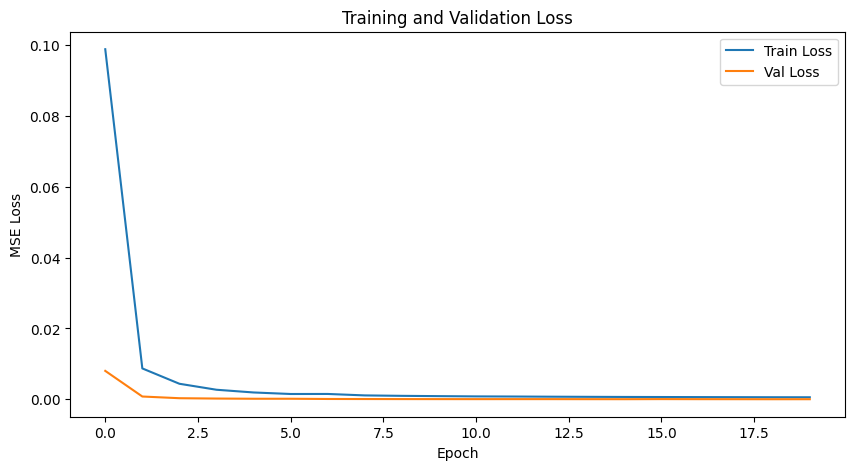

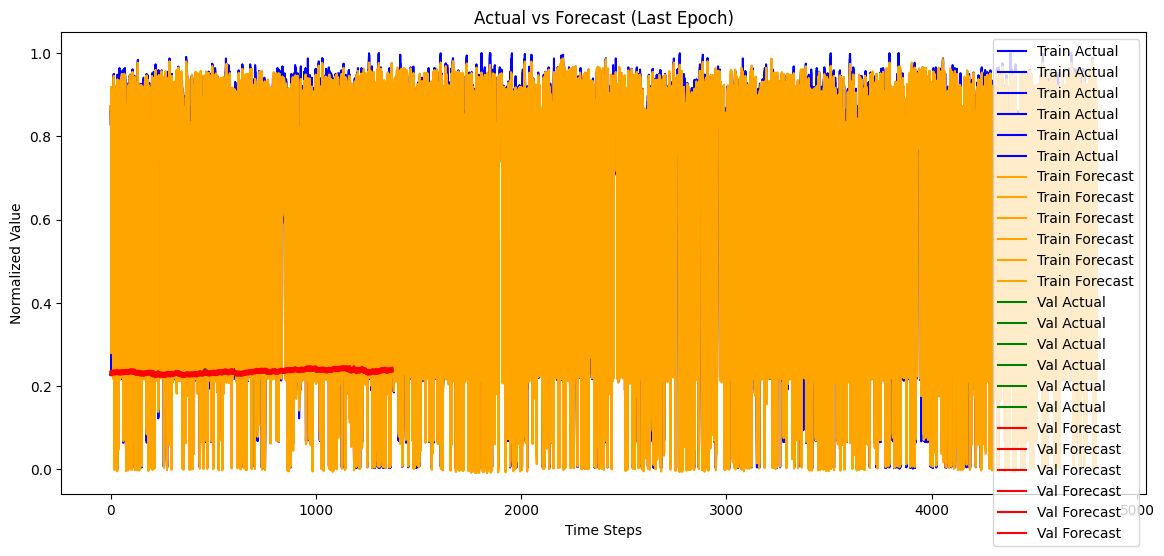

In [26]:
import matplotlib.pyplot as plt

# ----------------------------
# Training with storing forecasts
# ----------------------------
loss_history = []
val_loss_history = []

train_forecasts_all = []
train_targets_all = []
val_forecasts_all = []
val_targets_all = []

for epoch in range(epochs):
    # ----- Training -----
    model.train()
    total_loss = 0
    train_forecasts_epoch = []
    train_targets_epoch = []

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        backcast, forecast = model(x_batch)
        loss = loss_fn(forecast, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)

        # Store predictions and targets for plotting
        train_forecasts_epoch.append(forecast.detach().cpu().numpy())
        train_targets_epoch.append(y_batch.detach().cpu().numpy())

    avg_train_loss = total_loss / len(train_dataset)
    loss_history.append(avg_train_loss)
    train_forecasts_all.append(np.concatenate(train_forecasts_epoch))
    train_targets_all.append(np.concatenate(train_targets_epoch))

    # ----- Validation -----
    model.eval()
    val_total_loss = 0
    val_forecasts_epoch = []
    val_targets_epoch = []

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            _, val_forecast = model(x_val)
            val_loss = loss_fn(val_forecast, y_val)
            val_total_loss += val_loss.item() * x_val.size(0)

            val_forecasts_epoch.append(val_forecast.cpu().numpy())
            val_targets_epoch.append(y_val.cpu().numpy())

    avg_val_loss = val_total_loss / len(val_dataset)
    val_loss_history.append(avg_val_loss)
    val_forecasts_all.append(np.concatenate(val_forecasts_epoch))
    val_targets_all.append(np.concatenate(val_targets_epoch))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

# ----------------------------
# Plot Loss Curves
# ----------------------------
plt.figure(figsize=(10,5))
plt.plot(loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# ----------------------------
# Plot Last Epoch Predictions vs Actual
# ----------------------------
plt.figure(figsize=(14,6))
plt.plot(train_targets_all[-1], label="Train Actual", color='blue')
plt.plot(train_forecasts_all[-1], label="Train Forecast", color='orange')
plt.plot(val_targets_all[-1], label="Val Actual", color='green')
plt.plot(val_forecasts_all[-1], label="Val Forecast", color='red')
plt.title("Actual vs Forecast (Last Epoch)")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Value")
plt.legend()
plt.show()


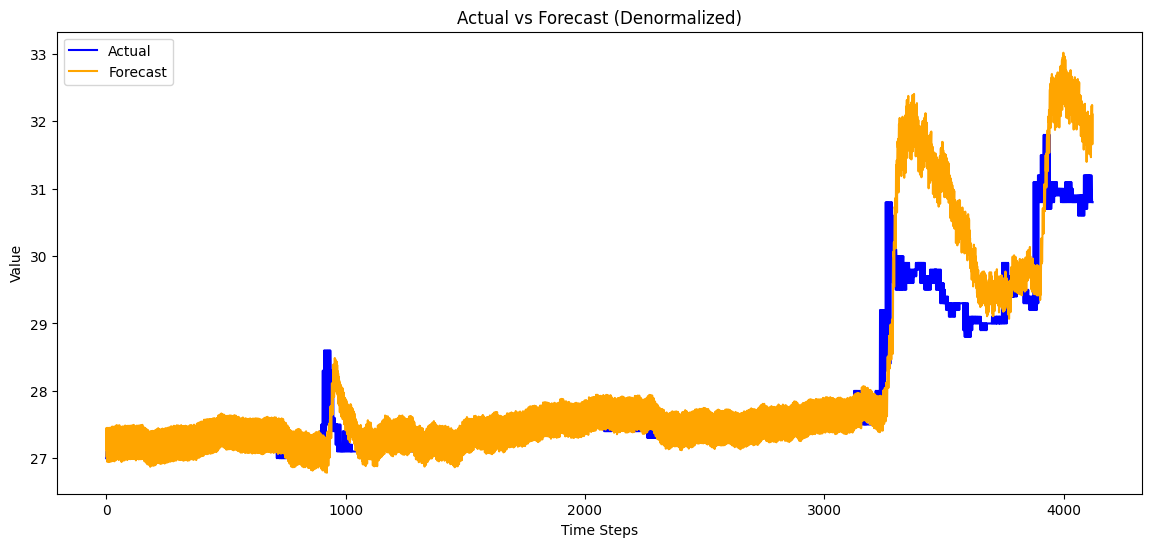

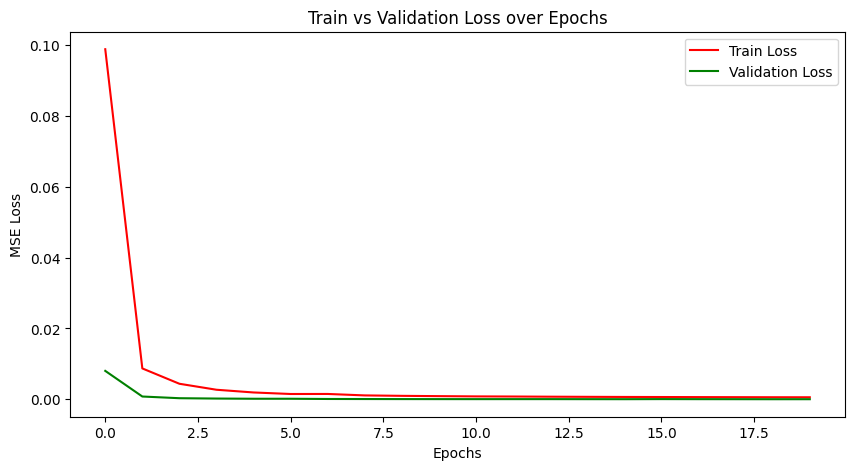

In [27]:
# ----------------------------
# 1. Test / Forecast
# ----------------------------
model.eval()
all_forecasts = []
all_targets = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:  # ensure this is your test split
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # Squeeze if extra dimension exists
        if x_batch.dim() == 3:
            x_batch = x_batch.squeeze(-1)
        if y_batch.dim() == 3:
            y_batch = y_batch.squeeze(-1)
        
        _, forecast = model(x_batch)
        forecast = forecast.cpu().numpy().reshape(-1)
        target = y_batch.cpu().numpy().reshape(-1)
        
        all_forecasts.append(forecast)
        all_targets.append(target)

all_forecasts = np.concatenate(all_forecasts)
all_targets = np.concatenate(all_targets)

# ----------------------------
# 2. Denormalize
# ----------------------------
all_forecasts_denorm = all_forecasts * (series_max - series_min) + series_min
all_targets_denorm = all_targets * (series_max - series_min) + series_min

# ----------------------------
# 3. Plot Actual vs Forecast
# ----------------------------
plt.figure(figsize=(14,6))
plt.plot(all_targets_denorm, label="Actual", color='blue')
plt.plot(all_forecasts_denorm, label="Forecast", color='orange')
plt.title("Actual vs Forecast (Denormalized)")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.show()

# ----------------------------
# 4. Plot Training and Validation Loss
# ----------------------------
plt.figure(figsize=(10,5))
plt.plot(loss_history, label="Train Loss", color='red')
plt.plot(val_loss_history, label="Validation Loss", color='green')
plt.title("Train vs Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


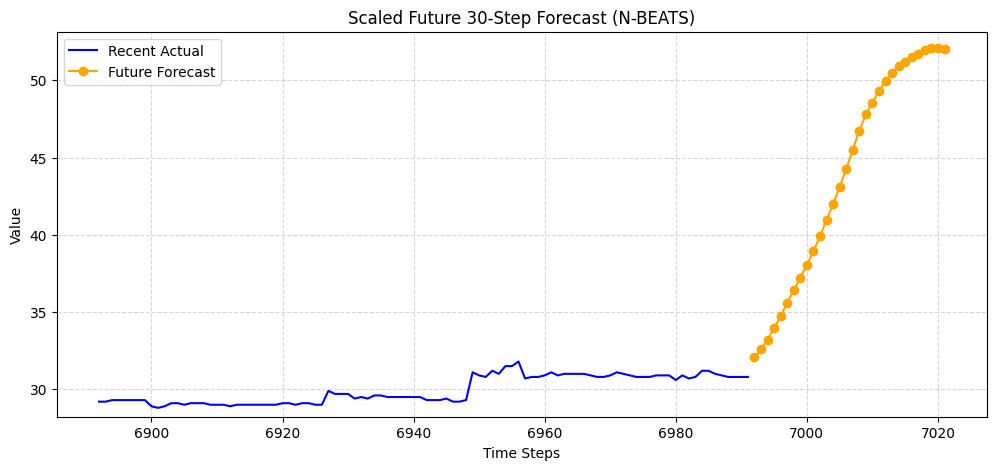

In [28]:
model.eval()
future_steps = 30  # number of steps you want to forecast
future_forecast = []

# start from the last known input sequence
current_seq = X_test[-1:].to(device)  # shape [1, backcast_length, 1] or [1, backcast_length]

with torch.no_grad():
    for _ in range(future_steps):
        # ensure correct shape
        if current_seq.dim() == 3:
            current_seq = current_seq.squeeze(-1)  # -> [1, backcast_length]
        
        # forward pass through N-BEATS
        _, forecast_step = model(current_seq)
        forecast_value = forecast_step.cpu().numpy().reshape(-1)[0]
        future_forecast.append(forecast_value)

        # convert forecast to tensor and reshape
        forecast_tensor = torch.tensor([[forecast_value]], dtype=torch.float32).to(device)

        # maintain fixed window size (slide one step forward)
        current_seq = torch.cat([current_seq[:, 1:], forecast_tensor], dim=1)

# ----------------------------
# Denormalize forecast
# ----------------------------
future_forecast = np.array(future_forecast)
future_forecast_denorm = future_forecast * (series_max - series_min) + series_min

# ----------------------------
# Plot actual + forecast
# ----------------------------
plt.figure(figsize=(12, 5))

# Choose last part of series to zoom into (e.g. last 100 points)
zoom_window = 100
recent_series = series[-zoom_window:]

# X-axis for recent part and forecast
x_recent = np.arange(len(series) - zoom_window, len(series))
x_future = np.arange(len(series), len(series) + future_steps)

plt.plot(x_recent, recent_series, label="Recent Actual", color="blue")
plt.plot(x_future, future_forecast_denorm, label="Future Forecast", color="orange", marker="o")

# Scale Y-axis slightly above and below visible range for clarity
y_min = min(np.min(recent_series), np.min(future_forecast_denorm)) * 0.98
y_max = max(np.max(recent_series), np.max(future_forecast_denorm)) * 1.02
plt.ylim(y_min, y_max)

plt.title(f"Scaled Future {future_steps}-Step Forecast (N-BEATS)")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [29]:
import json
import os

SAVE_DIR = "../saved_model"
os.makedirs(SAVE_DIR, exist_ok=True)

# === 1️⃣ Save model weights ===
torch.save(model.state_dict(), os.path.join(SAVE_DIR, "model.pth"))

# === 2️⃣ Save normalization info ===
scaling_info = {
    "series_min": float(series_min),
    "series_max": float(series_max)
}
with open(os.path.join(SAVE_DIR, "scaling.json"), "w") as f:
    json.dump(scaling_info, f)

# === 3️⃣ Save model configuration ===
config = {
    "backcast_length": backcast_length,
    "forecast_length": forecast_length,
    "hidden_units": hidden_layer_units,
    "stack_types": ["trend", "seasonality"],  # adjust if you used different
    "nb_blocks_per_stack": nb_blocks_per_stack
}
with open(os.path.join(SAVE_DIR, "config.json"), "w") as f:
    json.dump(config, f)

print("✅ Model, scaling, and config saved for real-time forecasting.")


✅ Model, scaling, and config saved for real-time forecasting.
